In [1]:
import sys
import seaborn as sns
import os
import glob
from matplotlib import pyplot as plt
import numpy as np
import plot as pltfn
from sklearn.cluster import KMeans
import network as netfn
import admin_functions as adfn
#plt.style.use('dark_background')
sns.reset_orig()
%load_ext autoreload
%autoreload

# Define paths
#---------------------------------------------------------------------------
Fdrop = '/Users/dominicburrows/Dropbox/PhD/analysis/'
Fmac = '/Users/dominicburrows/Documents/'
F10t = '/Volumes/Dominic 10tb/'
Ffig = '/Users/dominicburrows/Dropbox/PhD/figures/'
Ftm = '/Volumes/Dominic Time Machine/'
experiment = 'PTZ-WILDTYPE'
savepath = Fdrop + 'Project/' + experiment + os.sep 

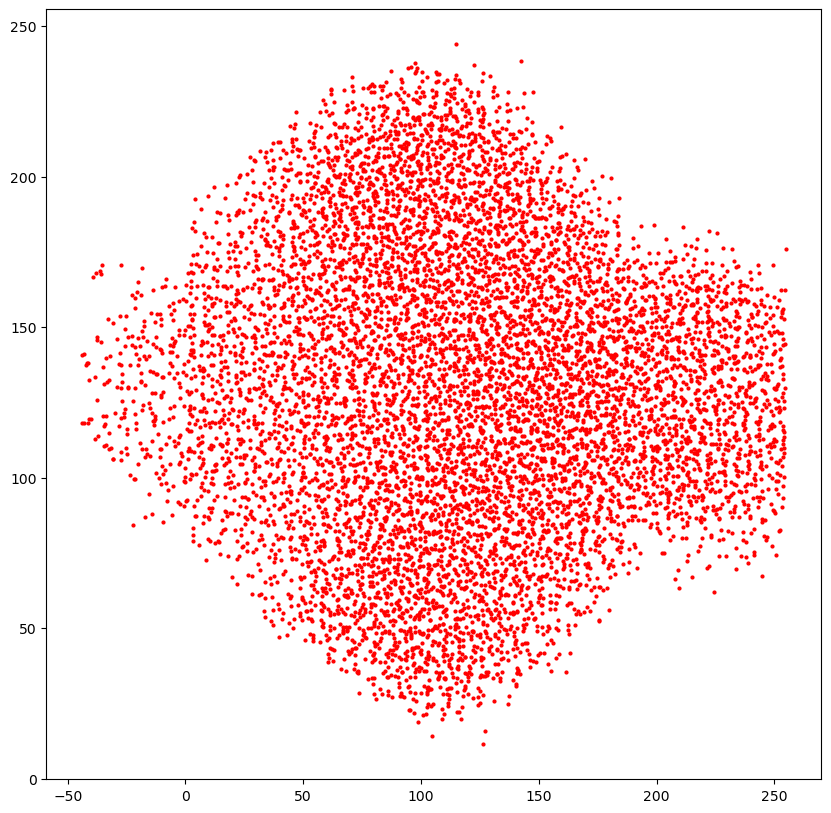

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy

# Node coordinates
#---------------------------------------------------------------------------
os.chdir(Fdrop + 'Project/' + experiment)
node = sorted(glob.glob('knodes*'))
fig,axarr = plt.subplots(figsize = (10,10))
nodes = np.load(node[0])
axarr.scatter(nodes[:,0], nodes[:,1], s = 4, color = 'red' , alpha = 1)
plt.show()

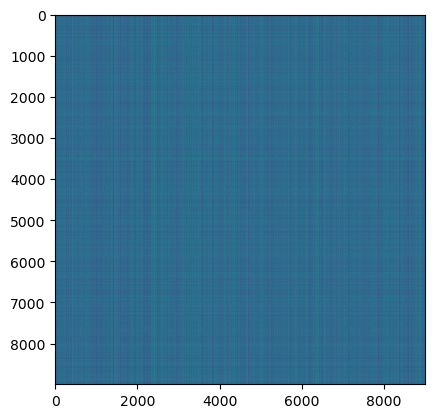

In [3]:
#K LOG + P LOG SCALE 
import numpy as np
import matplotlib.pyplot as plt
p_vals = np.geomspace(0.001, 1, 20)
k_vals = np.geomspace(1/nodes.shape[0], 0.5, 20)
cell_locs = nodes
dist = euclidean_distances(nodes)
plt.imshow(dist)
plt.show()

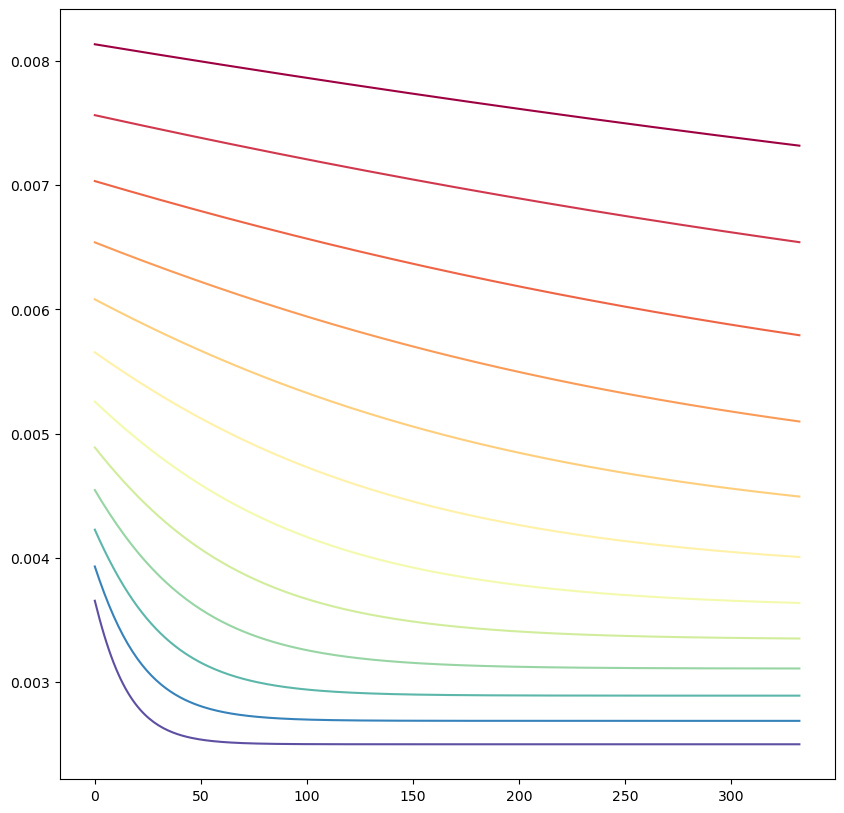

In [4]:
# Simple sigmoid function to 'soften' the exponential
#-------------------------------------------------------------------------------
def sig(x):
  return 1 / (1+np.exp(-x))

# Conversion from distance to edge weights, scaled (itself exponentially) by s
#-------------------------------------------------------------------------------
def dist2edge(distance, divisor, s):
  edgeweights = np.exp(s/5)*sig(np.exp(-soften/np.exp(s)*distance))/divisor
  return edgeweights

#S parameters
Nsteps  = 12
divisor = 200
soften = 0.07
s_vals   = np.array(np.linspace(0, 4, Nsteps)).tolist()

#Plot each s value
fig, ax = plt.subplots(1, figsize=(10,10))
colors  = cm.Spectral_r(np.linspace(0,1,Nsteps))
distance = np.linspace(0, np.max(dist), 300)
for s in range(len(s_vals)):
  ax.plot(distance, dist2edge(distance, divisor, s_vals[s]), c=colors[s])
plt.show()


In [5]:
# Choose path and create lists of coord and trace files
#---------------------------------------------------------------------------
experiment = 'PTZ-WILDTYPE'
os.chdir(Fdrop + 'Project/' + experiment)
blnlist = sorted(glob.glob('*BLN*_av.npy*'))[:1]
p20list = sorted(glob.glob('*PTZ20*_av.npy*'))[:1]

In [6]:
choose = 0
bln_distlist = [np.load(blnlist[i])[choose] for i in range(len(blnlist))]
p20_distlist = [np.load(p20list[i])[choose] for i in range(len(p20list))]
bln_vec = []
p20_vec = []
for i in range(len(bln_distlist)):
    bln_vec = np.append(bln_vec, bln_distlist[i])
    p20_vec = np.append(p20_vec, p20_distlist[i])

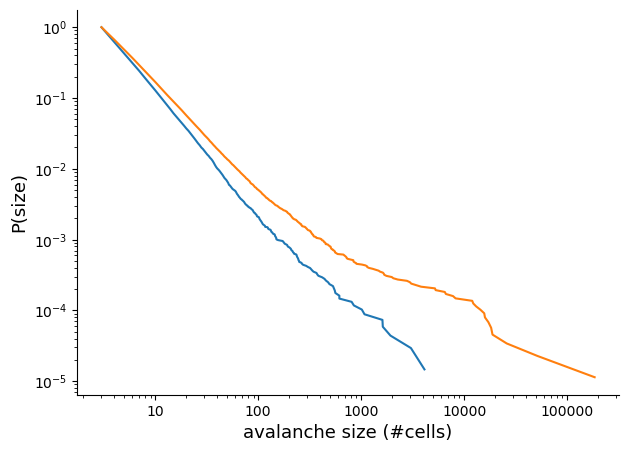

In [7]:
import matplotlib
import powerlaw
os.chdir(Fdrop + 'Project/' + experiment)
fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
avdistcut = bln_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1)
avdistcut = p20_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1)

axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

In [8]:
#Calculate number of simulatons to do - to have 95% chance of generating maximum avalanche
def num_sims(empirical, cutoff):
    import matplotlib.pyplot as plt
    import math
    fig, axarr = plt.subplots(figsize = (7,5))
    hist = axarr.hist(empirical, bins = 100000, density = True, histtype = 'step', cumulative = -1)
    p = 1-(10**(np.log10(hist[0])[np.where(np.log10(hist[1]) > np.log10(cutoff))[0][0]])) #probability of getting avalanches of size cutoff or smaller
    number = 0.05 
    base = p
    exponent = int(math.log(number, base)) #number of simulations as the power to which p is raised to get 95% probability 
    return(exponent)

#Simulation parameters
#======================
cutoff = 1000
n_sims= num_sims(bln_vec, cutoff)
n_sims

29156

In [28]:
import random
s0 = random.uniform(0, 5)
k0 = random.randint(10, 40)

print('divisor = ' + str(divisor))
print('soften = ' + str(soften))
print('cutoff = ' + str(cutoff))
print('n_sims = ' + str(n_sims))
print('s0 = ' + str(s0))
print('k0 = ' + str(k0))

divisor = 200
soften = 0.07
cutoff = 1000
n_sims = 29156
s0 = 3.1182764597542785
k0 = 10


In [ ]:
#Parameter sweep
from scipy.optimize import minimize
from scipy.optimize import brute
from scipy import stats
total_list = []
def ks_dist(params):
    print(params)  # <-- you'll see that params is a NumPy array
    s, k  = params # <-- for readability you may wish to assign names to the component variables
    avs = netfn.ba_netsim(dist).simulate(s, int(k), 0,  divisor, soften, cutoff, n_sims, 1).av_size
    ks = stats.ks_2samp(empirical, avs)[0]
    total_list.append([params, ks, avs])
    print('ks = ' + str(ks))
    return ks

#Define params
empirical = p20_vec
dist = dist
ranges = (slice(0, 15, 0.1), slice(2, 10, 1))
result = brute(ks_dist, ranges)

In [10]:
os.chdir(Fdrop + 'Project/' + experiment)

costlist, paramlist, avlist = list(range(len(total_list))), list(range(len(total_list))), list(range(len(total_list)))
for i in range(len(total_list)):
    paramlist[i] = total_list[i][0]
    costlist[i] = total_list[i][1]
    avlist[i] = total_list[i][2]
    
np.save('optimise_brute_ksdistlow_ba_p20f1_params.npy',   paramlist)
np.save('optimise_brute_ksdistlow_ba_p20f1_cost.npy',    costlist)
np.save('optimise_brute_ksdistlow_ba_p20f1_avs.npy',  avlist)

print('iterations = ' + str(len(costlist)) + '  true min = ' + str(np.where(costlist == np.min(costlist))[0][0]))
print('min cost = ' + str(costlist[np.where(costlist == np.min(costlist))[0][0]]))
print('min params = ' + str(paramlist[np.where(costlist == np.min(costlist))[0][0]]))
curr = avlist[np.where(costlist == np.min(costlist))[0][0]]

iterations = 1603  true min = 1280
min cost = 0.008736868685800259
min params = [7.33359864 8.10312262]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     

# Node coordinates
#---------------------------------------------------------------------------
os.chdir(Fdrop + 'Project/' + experiment)
avlist = sorted(glob.glob('optimise*ks*ba+*avs.npy'))
costlist = sorted(glob.glob('optimise*ks*ba+*cost.npy'))
paramlist = sorted(glob.glob('optimise*ks*ba+*params.npy'))
avlist, costlist, paramlist

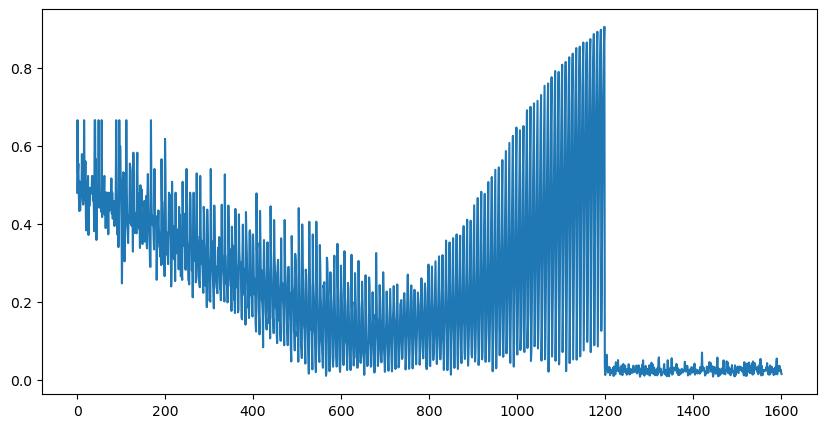

In [12]:
fig = plt.figure(figsize= (10,5))
plt.plot(np.arange(0, len(costlist)), costlist)
plt.show()

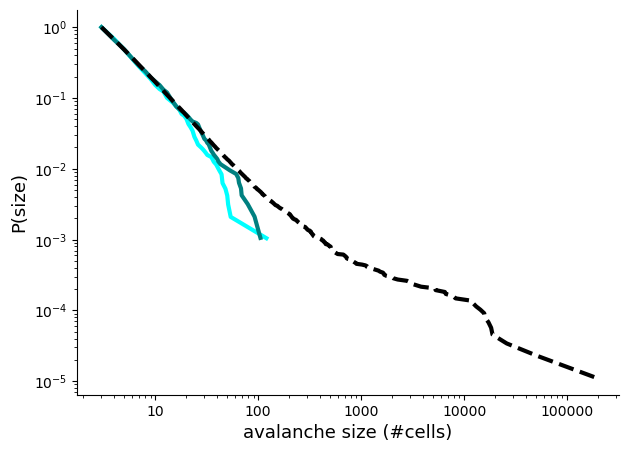

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     
import scipy
os.chdir(F10t + 'Project/' + experiment)


import matplotlib
import powerlaw

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
                   

avdistcut = avlist[-1]
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'cyan')

avdistcut = avlist[np.where(costlist == np.min(costlist))[0][0]]
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'teal')

avdistcut = empirical
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =3 , markersize = 3, alpha = 1, c = 'k')
        
        
axarr.set_xscale('log')
axarr.set_yscale('log')    
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)

plt.show()

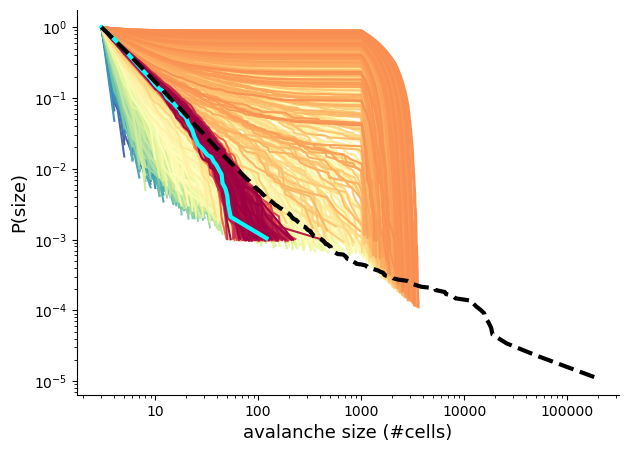

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     
import scipy
os.chdir(F10t + 'Project/' + experiment)


colors = cm.Spectral_r(np.linspace(0, 1, len(total_list)))

#Cycle length - small network
import matplotlib
import powerlaw

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
                   
# Node coordinates
#---------------------------------------------------------------------------
for i in range(len(total_list)):
    av_dense = total_list[i][2]
    powerlaw.plot_ccdf(av_dense, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = colors[i])
    

avdistcut = total_list[-1][2]
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'cyan')

avdistcut = empirical
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =3 , markersize = 3, alpha = 1, c = 'k')
        
        
axarr.set_xscale('log')
axarr.set_yscale('log')    
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)

plt.show()

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     

# Node coordinates
#---------------------------------------------------------------------------
os.chdir(Fdrop + 'Project/' + experiment)
avlist = sorted(glob.glob('optimise*ks*low*ba*avs.npy'))
costlist = sorted(glob.glob('optimise*ks*low*ba*cost.npy'))
paramlist = sorted(glob.glob('optimise*ks*low*ba*params.npy'))
avlist, costlist, paramlist

(['optimise_brute_ksdistlow_ba_blnf1_avs.npy',
  'optimise_brute_ksdistlow_ba_p20f1_avs.npy'],
 ['optimise_brute_ksdistlow_ba_blnf1_cost.npy',
  'optimise_brute_ksdistlow_ba_p20f1_cost.npy'],
 ['optimise_brute_ksdistlow_ba_blnf1_params.npy',
  'optimise_brute_ksdistlow_ba_p20f1_params.npy'])

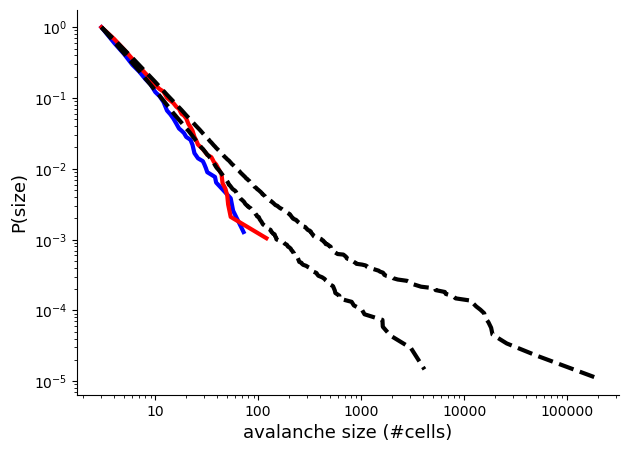

baseline = [8.85222392 5.06457948]
ptz = [7.33359864 8.10312262]


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     
import scipy

import matplotlib
import powerlaw

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
                   
avdistcut = np.load(avlist[0], allow_pickle=True)[-1]
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'blue')

avdistcut = np.load(avlist[1], allow_pickle=True)[-1]
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'red')

avdistcut = bln_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =3 , markersize = 3, alpha = 1, c = 'k')

avdistcut =p20_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =3 , markersize = 3, alpha = 1, c = 'k')
        
        
axarr.set_xscale('log')
axarr.set_yscale('log')    
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)

plt.show()

print('baseline = ' + str(np.load(paramlist[0], allow_pickle=True)[-1]))
print('ptz = ' + str(np.load(paramlist[1], allow_pickle=True)[-1]))

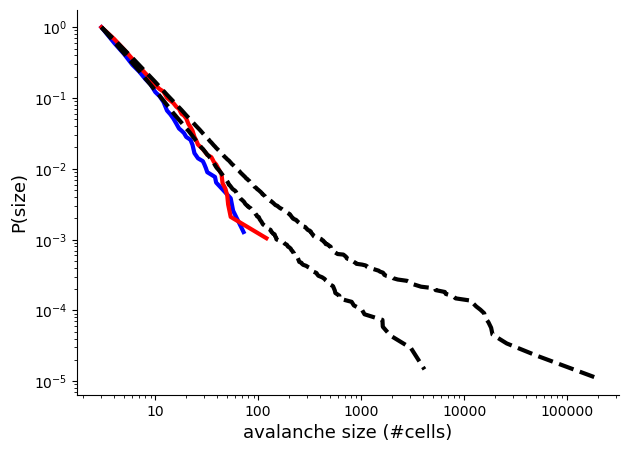

baseline = [8.85222392 5.06457948]
ptz = [7.33359864 8.10312262]


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     
import scipy

import matplotlib
import powerlaw

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
                   
avdistcut = np.load(avlist[0], allow_pickle=True)[-1]
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'blue')

avdistcut = np.load(avlist[1], allow_pickle=True)[-1]
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'red')

avdistcut = bln_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =3 , markersize = 3, alpha = 1, c = 'k')

avdistcut =p20_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =3 , markersize = 3, alpha = 1, c = 'k')
        
        
axarr.set_xscale('log')
axarr.set_yscale('log')    
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)

plt.show()

print('baseline = ' + str(np.load(paramlist[0], allow_pickle=True)[-1]))
print('ptz = ' + str(np.load(paramlist[1], allow_pickle=True)[-1]))

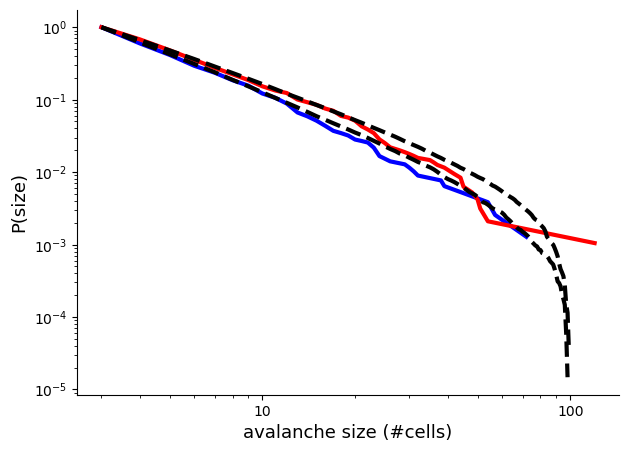

baseline = [8.85222392 5.06457948]
ptz = [7.33359864 8.10312262]


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     
import scipy

import matplotlib
import powerlaw

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
                   
avdistcut = np.load(avlist[0], allow_pickle=True)[-1]
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'blue')

avdistcut = np.load(avlist[1], allow_pickle=True)[-1]
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'red')

avdistcut = bln_vec[np.where(bln_vec < 100)[0]]
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =3 , markersize = 3, alpha = 1, c = 'k')

avdistcut =p20_vec[np.where(p20_vec < 100)[0]]
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =3 , markersize = 3, alpha = 1, c = 'k')
        
        
axarr.set_xscale('log')
axarr.set_yscale('log')    
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)

plt.show()

print('baseline = ' + str(np.load(paramlist[0], allow_pickle=True)[-1]))
print('ptz = ' + str(np.load(paramlist[1], allow_pickle=True)[-1]))

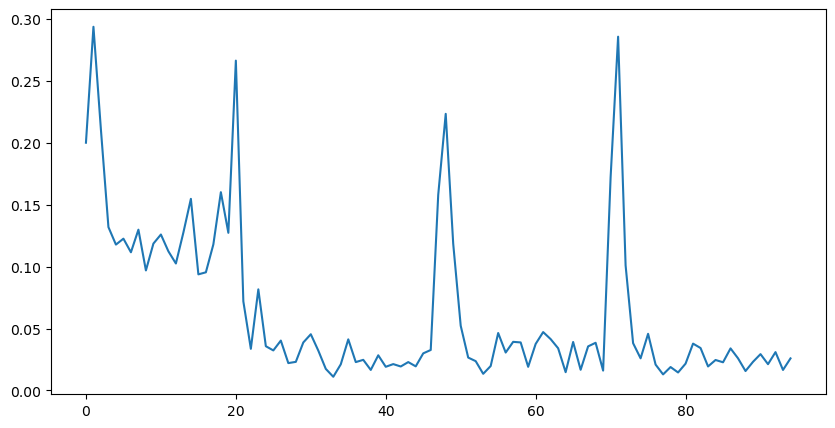

In [39]:
fig = plt.figure(figsize= (10,5))
plt.plot(np.arange(0, len(costlist)), costlist)
plt.show()